In [447]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [448]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_math.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Templated suffix, single-output decoding',
    'Avg suffix': 'Templated suffix, average-output decoding',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(SUFFIX_LEGEND_REMAP)
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))


# drop results for other models, n_shots == 10, single-query ones.
suffix_results = suffix_results[
      (suffix_results["checkpoint"] == "EleutherAI/gpt-j-6B")
    & (suffix_results["n_shots"] < 10)
    & (suffix_results["use_single_query"] == "Avg suffix")
]

In [449]:
suffix_results["legend"]

41     Templated suffix, average-output decoding
35     Templated suffix, average-output decoding
37     Templated suffix, average-output decoding
43     Templated suffix, average-output decoding
48     Templated suffix, average-output decoding
33     Templated suffix, average-output decoding
49     Templated suffix, average-output decoding
53     Templated suffix, average-output decoding
61     Templated suffix, average-output decoding
64     Templated suffix, average-output decoding
0      Templated suffix, average-output decoding
9      Templated suffix, average-output decoding
28     Templated suffix, average-output decoding
76     Templated suffix, average-output decoding
98     Templated suffix, average-output decoding
92     Templated suffix, average-output decoding
107    Templated suffix, average-output decoding
94     Templated suffix, average-output decoding
82     Templated suffix, average-output decoding
99     Templated suffix, average-output decoding
Name: legend, dtype:

In [450]:
suffix_results[['checkpoint',  'task_name', 'n_shots']].value_counts()

checkpoint           task_name      n_shots
EleutherAI/gpt-j-6B  add_two        1          1
                                    5          1
                     subtract_two   1          1
                     square_one     5          1
                                    1          1
                     multiply_two   5          1
                                    1          1
                     max_two        5          1
                                    1          1
                     first_two      5          1
                                    1          1
                     fibonacci_one  5          1
                                    1          1
                     exp_one        5          1
                                    1          1
                     double_one     5          1
                                    1          1
                     divide_two     5          1
                                    1          1
                     subt

In [451]:
from typing import Dict

nice_method_names = {
    'autoprompt': 'AutoPrompt',
    'genetic': 'EvoPrompt',
}
def get_legend__autoprompt(row: Dict) -> str:
    nt = f'{row["num_learned_tokens"]} tokens'
    return nice_method_names.get(row["model_cls"]) + f' ({nt})'


autoprompt_save_dir = '/home/johnmorris/interpretable-autoprompting/results/autoprompt_arithmetic'

raw_autoprompt_results = analyze_utils.load_results_and_cache_autoprompt_json(autoprompt_save_dir, save_file='r.pkl')
autoprompt_results = raw_autoprompt_results.groupby(['model_cls', 'task_name', 'n_shots', 'num_learned_tokens']).first().reset_index()
autoprompt_results["legend"] = autoprompt_results.apply(get_legend__autoprompt, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 118.43it/s]


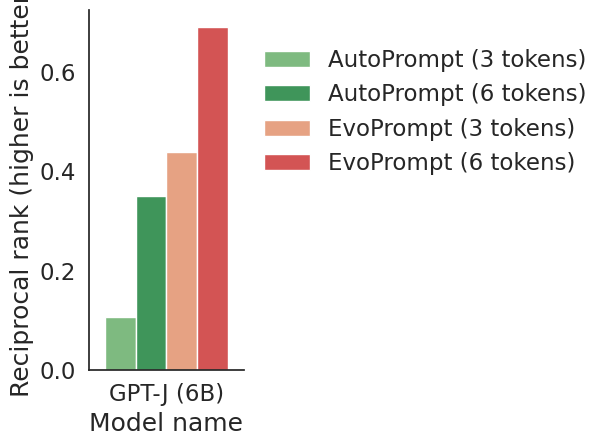

In [452]:
# metric_key = 'final_answer_pos_initial_token'
# metric_key = f'Recall @ {5} suffixes'
metric_key = 'reciprocal_rank'
tab = (
    (autoprompt_results
        # (mean over templates, task_name)
        .groupby(['checkpoint', 'legend'])[[metric_key]]
        .mean()
        .reset_index()
    )
)
analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)

In [453]:
r = pd.concat((suffix_results, autoprompt_results), axis=0)

pd.set_option('display.max_rows', 100)

r.groupby(["legend", "task_name", "n_shots"])[["reciprocal_rank", "prefixes", "max_digit"]].first()

reciprocal_rank  \
legend                                    task_name     n_shots                    
AutoPrompt (3 tokens)                     add_two       1               0.035714   
                                                        5               1.000000   
                                          divide_two    1               0.000100   
                                                        5               0.000100   
                                          double_one    1               0.000100   
                                                        5               0.000100   
                                          exp_one       1               0.000100   
                                                        5               0.000100   
                                          fibonacci_one 1               0.000100   
                                                        5               0.000100   
                                          first_two     1               0.000100   
                                                        5               0.000100   
                                          max_two       1               0.000100   
                                                        5               0.000100   
                                          multiply_two  1               1.000000   
                                                        5               0.000100   
                                          square_one    1               0.000100   
                                                        5               0.000100   
                                          subtract_two  1               0.000100   
AutoPrompt (6 tokens)                     add_two       1               1.000000   
                                                        5               1.000000   
                                          divide_two    1               0.000100   
                                                        5               0.000100   
                                          double_one    1               0.000100   
                                                        5               0.000100   
                                          exp_one       1               0.009009   
                                                        5               0.010101   
                                          fibonacci_one 1               0.000100   
                                                        5               0.000100   
                                          first_two     1               0.000100   
                                                        5               1.000000   
                                          max_two       1               0.000100   
                                                        5               0.000100   
                                          multiply_two  1               1.000000   
                                                        5               1.000000   
                                          square_one    1               0.000100   
                                                        5               0.000100   
                                          subtract_two  1               1.000000   
                                                        5               1.000000   
EvoPrompt (3 tokens)                      add_two       1               1.000000   
                                                        5               1.000000   
                                          divide_two    1               1.000000   
                                                        5               0.000100   
                                          double_one    1               0.125000   
                                                        5               0.125000   
                                          exp_one       1               0.007812   
                                 

In [454]:
tn = r[["task_name"]].value_counts().reset_index()
finished_task_names = tn[tn[0]==tn[0].max()]["task_name"].tolist()
rf = r[r["task_name"].map(lambda t: t in finished_task_names)] # r_finished

In [372]:
len(r), len(rf)

(98, 80)

In [373]:
len(suffix_results), len(autoprompt_results)

(20, 78)

In [445]:
autoprompt_results.groupby(['model_cls', 'n_shots', 'task_name'])['reciprocal_rank'].mean()

model_cls   n_shots  task_name    
autoprompt  1        add_two          0.517857
                     divide_two       0.000100
                     double_one       0.000100
                     exp_one          0.004554
                     fibonacci_one    0.000100
                     first_two        0.000100
                     max_two          0.000100
                     multiply_two     1.000000
                     square_one       0.000100
                     subtract_two     0.500050
            5        add_two          1.000000
                     divide_two       0.000100
                     double_one       0.000100
                     exp_one          0.005101
                     fibonacci_one    0.000100
                     first_two        0.500050
                     max_two          0.000100
                     multiply_two     0.500050
                     square_one       0.000100
                     subtract_two     1.000000
genetic     1        add_

<Figure size 900x500 with 0 Axes>

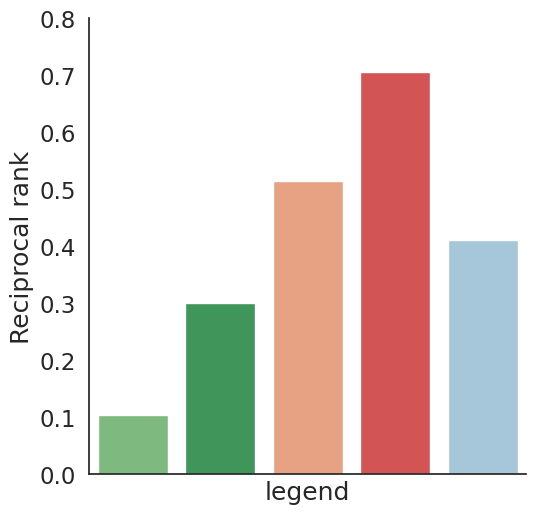

<Figure size 640x480 with 0 Axes>

In [487]:
sns.set_theme(font_scale=1.5, style="white")
for metric_key in [
                 'reciprocal_rank',
                #  'final_answer_pos_initial_token',
                #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    tab = (
        (r[r['n_shots'] == 1]
            # (mean over templates, task_name)
            .groupby(['legend'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    hue_order = analyze_utils.get_hue_order(tab['legend'])
    plt.figure(figsize=(9,5))
    
    g = sns.catplot(
        kind='bar',
        data=tab,
        y='reciprocal_rank',
        hue='legend',
        x='legend',
        # hue_order=hue_order,
        palette=analyze_utils.COLORS,
        # facet_kws={'legend_out': True},
        legend=True,
        # legend=False,
        # figsize=(15,9)
        dodge=False, # make the bars nice and snug
    )
    for ax in g.axes.flat:
        ax.set_xticks([])
    g.fig.set_figwidth(15)
    g.fig.set_figheight(6)
    plt.ylim((0.0, 0.8))
    plt.ylabel('Reciprocal rank')
    plt.legend(bbox_to_anchor=(1, 0.95))
    if metric_key == 'reciprocal_rank':
        plt.savefig('../results/prompt_gen/joint_math_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_math_{metric_key}.pkl')
    plt.legend('', frameon=False)
    plt.show()
    plt.tight_layout()

### Plot the best model

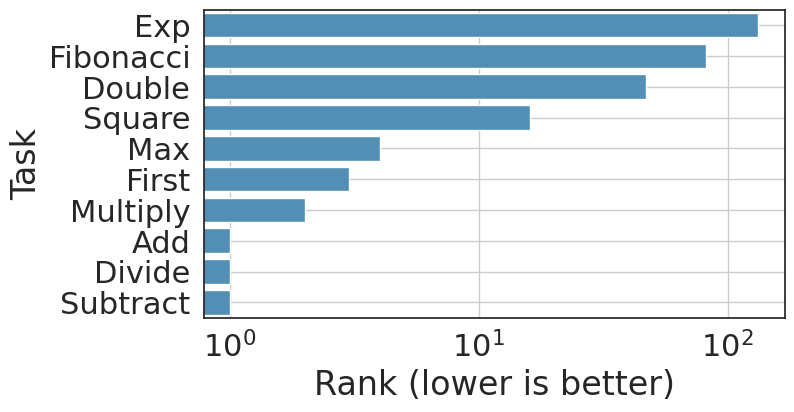

In [185]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name]) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Suffix, average-output decoding (4-shot)')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

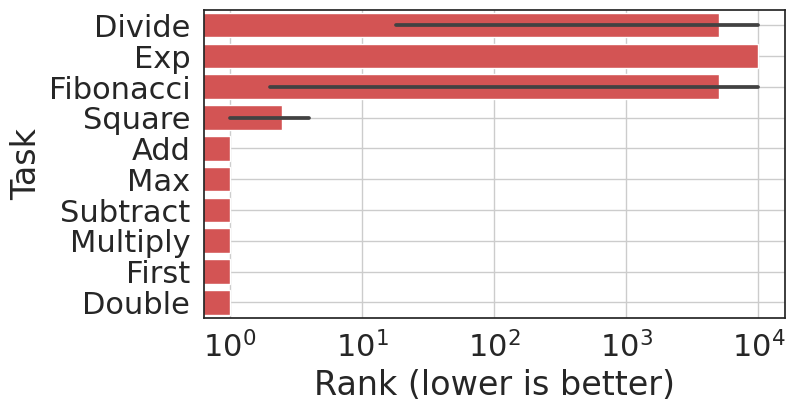

In [ ]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name]) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='EvoPrompt (6 tokens)')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

In [21]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name]) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Suffix, average-output decoding (4-shot)')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

fibonacci_one    4
square_one       4
double_one       4
exp_one          4
multiply_two     4
max_two          4
add_two          4
divide_two       4
first_two        4
subtract_two     4
Name: task_name, dtype: int64